### Libraries setup

In [ ]:
#!pip3 install -r requirements.txt
!pip3 install torchinfo numpy pandas nibabel torchio tqdm matplotlib SimpleITK scikit-learn

In [ ]:
#!unzip znorm_cropped_imgs.zip -d /storage

### Model testing

In [ ]:
from models.unet3d import UNet
from torchinfo import summary

samp_unet = UNet(1)
summary(samp_unet, (2,1,40,56,72))
#summary(samp_unet, (1,1,196,196,196))

### Train + Test

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

firstUNet = UNet(1)
train_history = train_model(
    model=firstUNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=train_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=100,
    learning_rate=0.0001
)

test_loss, test_met = start_eval(firstUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

In [ ]:
import numpy as np
import datetime

np.savez('train_hist.npz', **train_history)
save_model(firstUNet)

### Hold-out cross validation

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

tr_train_subj, tr_val_subj = split_train_subjects('/storage/harp_metadata.csv', train_subj, 18, 42)

secondUNet = UNet(1)
train_val_hist = hocv_train_model(
    model = secondUNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=tr_train_subj,
    val_ids=tr_val_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=200,
    learning_rate=0.00001
)

test_loss, test_met = start_eval(secondUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

### 5-fold Cross Validation

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, skfcv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=100,
    learning_rate=0.0001,
    kfold=5,
    random_seed=42
)

In [ ]:
import numpy as np
import datetime

np.savez('train_val_hist2.npz', **train_val_hist)
save_model(secondUNet)

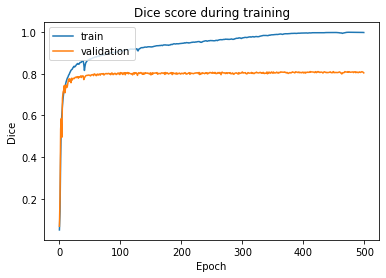

In [3]:
import numpy as np
from model_utils.metrics import plot_per_epoch
train_val_hist = np.load('train_val_hist500.npz')
train_val_hist = dict(train_val_hist)

plot_per_epoch(train_val_hist, [('train_metric_per_epoch', 'train'), ('val_metric_per_epoch', 'validation')], 'Dice', 'Dice score during training')

In [ ]:
train_hist = np.load('train_hist.npz')
train_hist = dict(train_hist)
train_hist

In [ ]:
# from model_utils.train_eval import model_predict
# from models.unet3d import UNet

# trialmod = UNet(1)
# model_predict(trialmod, 'znorm_cropped_imgs', '010_S_0067', 'l', model_file='saved_models/model_20062022_124835.pth')